<a href="https://colab.research.google.com/github/OfekYa/Deep-Learning/blob/main/implement_Tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1: An implementation of a Tensor constructor that samples random numbers from a discrete distribution that is received in the input.
# Q2: An implementation of an automatic derivation system. The system will follow mathematical operations performed on the variables and calculate together with each operation its immediate derivative

## **Q1:  my_sampler**

In [ ]:
import matplotlib.pyplot as plt
import torch


"""Checking that the sum of the probabilities is 1 and that every element in the vector is positive"""
def is_distribution_valid(dist):
    if (torch.all(dist > 0) and dist.sum() == 1.0):
        return True
    return False


def my_sampler(size, dist, requires_grad=False):

    dist = torch.tensor(dist)  # Convert the list "dist" to be tensor type.
    if is_distribution_valid(dist) == False:  # check validity of the distribution
        raise Exception('The given distribution is not valid.')

    dist = dist.cumsum(dim=0)  # Now each element in tensor "dist" holds the sum of the probabilities up to that element.
    sum_P_n = dist[-2]  # The sum of the probabilities up to the value: n-1.
    prev_sum_P_i = 0  # The sum of the probabilities up to the previous value: i-1.

    probabilities_tensor = torch.rand(size)  # Each element in the probabilities_tensor is a U that holds a value between 0 and 1.

    """ Initialize all I's to 0:  -->  I = 0.
        If a certain condition is met on U:  --> condition(U) == TRUE.
            then a placement is made on I:  -->  I = (I + k) or (I + n)   """
    result_tensor = torch.zeros(size)  # if (U < P(0)) then (I = 0).  a tensor of zeros will solve this requirement.

    """ Step 2 in the algorithm:
        if the value of the random variable is greater than or equal to the sum of the first n-1 probabilities:
            then we will return I = n """
    mask_by_condition_2 = (probabilities_tensor >= sum_P_n)  # if (U >= sum_P(n-1)) then (I is TRUE).
    n = mask_by_condition_2 * (len(dist) - 1)  # if (I is TRUE) then (I = n), else (I keeps the value 0).
    result_tensor = result_tensor + n  # Update the output tensor according to the elements that will be defined n.

    """ Steps 3 and 4 in the algorithm:
        if the value of the random variable is greater than or equal to the sum of the 
           first k-1 probabilities and smaller than the sum of the first k probabilities:
            then we will return I = k """
    for i in range(len(dist)-1):

        curr_sum_P_i = dist[i]  # The sum of the probabilities up to the current value: i.

        mask3_1 = (probabilities_tensor >= prev_sum_P_i)  # if (U >= sum_P(i-1)) then (I is TRUE).
        mask3_2 = (probabilities_tensor < curr_sum_P_i)  # if (U < sum_P(i)) then (I is TRUE).
        mask_by_condition_3 = mask3_1 & mask3_2   # if (sum_P(i) > U >= sum_P(i-1)) then (I is TRUE).
        k = mask_by_condition_3 * i  # if (I is TRUE) then (I = k), else (I remains 0 or n).
        result_tensor = result_tensor + k  # Update the output tensor according to the elements that will be defined k.

        prev_sum_P_i = dist[i]  # Update the sum of the probabilities up to the previous value: i-1.

    result_tensor.requires_grad_(requires_grad)
    return result_tensor


# **Test Q1:**

TEST 1
tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])
TEST 2
tensor([[2., 2., 2., 2., 0., 2., 1., 2., 2., 2.],
        [2., 0., 2., 2., 2., 2., 2., 2., 1., 2.]], requires_grad=True)
None


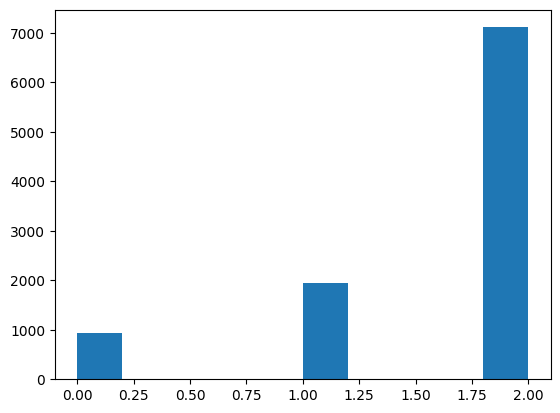

In [ ]:
print("TEST 1")
A = my_sampler(10,[0.5,0.5])
print(A)

print("TEST 2")
B = my_sampler((2,10), [0.1,0.2,0.7], requires_grad = True)
print(B,B.grad,sep='\n')


x = my_sampler(10000, [0.1,0.2,0.7])
plt.hist(x)
plt.show()



## **Q2: MyScalar**


In [ ]:
import torch

class MyScalar:

    def __init__(self, scalar_value, gradient_value = 1, parent = None):
        self.value = scalar_value
        self.gradient = gradient_value
        self.parent = parent
        self.parent_gradient = 1  # cumulative gradient value.

    def __repr__(self):
        return f"\nMyScalar (scalar value: {float(self.value)} ,gradient value:{float(self.gradient)} ,parent: {self.parent})"


    def __add__(self, other):
        value = torch.tensor(self.value + other)
        gradient = 1
        return MyScalar(value, gradient, self)

    def __mul__(self, other):
        value = torch.tensor(other * self.value)
        grad = other
        return MyScalar(value, grad, self)

    def __pow__(self, power):
        value = torch.tensor(self.value ** power)
        grad = power * (self.value ** (power - 1))
        return MyScalar(value, grad, self)

    def cosine(self):
        value = torch.cos(self.value)
        grad = -(torch.sin(self.value))
        return MyScalar(value, grad, self)

    def sine(self):
        value = torch.sin(self.value)
        grad = torch.cos(self.value)
        return MyScalar(value, grad, self)

    def ln(self):
        value = torch.log(self.value)  # Returns a new tensor with the natural logarithm of the elements of input.
        grad = 1 / self.value
        return MyScalar(value, grad, self)

    def exp(self):
        value = torch.exp(torch.tensor(self.value))
        grad = value
        return MyScalar(value, grad, self)


    def get_gradient(self):

        if self.parent is not None:
            gradient_dic[self] = self.parent_gradient
            self.parent.parent_gradient = self.gradient * self.parent_gradient
            MyScalar.get_gradient(self.parent)
        else: # אם self.parents = None אז הגענו לשורש הרקורסיה, כלומר לאיבר הראשון שבוצעה עליו פעולה
            gradient_dic[self] = self.gradient * self.parent_gradient

        return gradient_dic


gradient_dic = {}



# **TEST Math Functions:**

In [ ]:
x = MyScalar(4)
torch_x = torch.tensor([4.])
print("x: ", x)
print("torch_x: ", torch_x)

a = MyScalar.__add__(x, 3)
torch_a = torch.add(torch_x, 3)
print("\na: ", a.value)
print("torch_a: ", torch_a)

b = MyScalar.__mul__(x, 3)
torch_b = torch.mul(torch_x, 3)
print("\nb: ", b.value)
print("torch_b: ", torch_b)

c = MyScalar.__pow__(x, 2)
torch_c = torch.pow(torch_x, 2)
print("\nc: ", c.value)
print("torch_c: ", torch_c)

d = MyScalar.exp(x)
torch_d = torch.exp(torch_x)
print("\nd: ", d.value)
print("torch_d: ", torch_d)

e = MyScalar.ln(d)
torch_e = torch.log(torch_d)
print("\ne: ", e.value)
print("torch_e: ", torch_e)

f = MyScalar.cosine(e)
torch_f = torch.cos(torch_e)
print("\nf: ", f.value)
print("torch_f: ", torch_f)

g = MyScalar.sine(f)
torch_g = torch.sin(torch_f)
print("\ng: ", g.value)
print("torch_g: ", torch_g)


x:  
MyScalar (scalar value: 4.0 ,gradient value:1.0 ,parent: None)
torch_x:  tensor([4.])

a:  tensor(7)
torch_a:  tensor([7.])

b:  tensor(12)
torch_b:  tensor([12.])

c:  tensor(16)
torch_c:  tensor([16.])

d:  tensor(54.5981)
torch_d:  tensor([54.5981])

e:  tensor(4.)
torch_e:  tensor([4.])

f:  tensor(-0.6536)
torch_f:  tensor([-0.6536])

g:  tensor(-0.6081)
torch_g:  tensor([-0.6081])


# **TEST get_gradient:**

In [ ]:
a = MyScalar(2)
b = MyScalar.__pow__(a, 2)
c = MyScalar.exp(b)
#d = MyScalar.cosine(c)
#e = MyScalar.ln(d)
f = MyScalar.get_gradient(c)
print("f: ", f)


torch_a = torch.tensor([2.], requires_grad=True)
torch_b = torch.pow(torch_a, 2)
torch_c = torch.exp(torch_b)
#torch_d = torch.cos(torch_c)
#torch_e = torch.log(torch_d)

torch_c.backward()
print("torch_a: ", torch_a.grad)

f:  {
MyScalar (scalar value: 54.598148345947266 ,gradient value:54.598148345947266 ,parent: 
MyScalar (scalar value: 4.0 ,gradient value:4.0 ,parent: 
MyScalar (scalar value: 2.0 ,gradient value:1.0 ,parent: None))): 1, 
MyScalar (scalar value: 4.0 ,gradient value:4.0 ,parent: 
MyScalar (scalar value: 2.0 ,gradient value:1.0 ,parent: None)): tensor(54.5981), 
MyScalar (scalar value: 2.0 ,gradient value:1.0 ,parent: None): tensor(218.3926)}
torch_a:  tensor([218.3926])


<ipython-input-3-4b7a813d6a4f>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.exp(torch.tensor(self.value))
